In [3]:
import os
import numpy as np
import pandas as pd
import random
import shutil
import warnings
from PIL import Image # image processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory # load images from directory
from tensorflow.keras import callbacks # use EarlyStopping
from tensorflow.keras.preprocessing import image
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# CNN-SA-DCA

In [7]:
class SelfAttention(layers.Layer):
    def __init__(self, trainable=True, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        self.query_dense = layers.Dense(input_shape[-1])
        self.key_dense = layers.Dense(input_shape[-1])
        self.value_dense = layers.Dense(input_shape[-1])
        self.attention = layers.Attention()

    def call(self, inputs):
        queries = self.query_dense(inputs)
        keys = self.key_dense(inputs)
        values = self.value_dense(inputs)
        context = self.attention([queries, keys, values])
        return context

class DenseChannelAttention(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(DenseChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(self.channel // self.reduction_ratio, activation='relu')
        self.dense2 = layers.Dense(self.channel, activation='sigmoid')

    def call(self, inputs):
        avg_pool = self.avg_pool(inputs)
        dense1 = self.dense1(avg_pool)
        dense2 = self.dense2(dense1)
        scale = layers.Reshape((1, 1, self.channel))(dense2)
        return inputs * scale

    def get_config(self):
        config = super(DenseChannelAttention, self).get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio,
        })
        return config

In [10]:
from tensorflow.keras.models import load_model

custom_objects = {
    'DenseChannelAttention': DenseChannelAttention,
    'SelfAttention': SelfAttention
}

model= load_model('/kaggle/input/abelation-models/model-CNNSADCA (4).h5', custom_objects=custom_objects)


In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
import os

df = pd.read_csv('/kaggle/input/thcr-1/train.csv')


image_path = '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/'


def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(64, 64))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_processed,verbose=0)
    index = np.argmax(prediction)
    return index


df_first_10000 = df.head(10000)


df_first_10000['Predicted_Class_Label'] = df_first_10000['ID'].apply(
    lambda x: predict_image(os.path.join(image_path, f"{x}"), model)
)

df_first_10000.to_csv('/kaggle/working/updated_train_CNN-SA-DCA.csv', index=False)

Accuracy: 0.8749
Precision (Macro Average): 0.8770
Recall (Macro Average / Sensitivity): 0.8683
F1 Score (Macro Average): 0.8690
Specificity (Macro Average): 0.9992
Precision (Micro Average): 0.8749
Recall (Micro Average): 0.8749
F1 Score (Micro Average): 0.8749


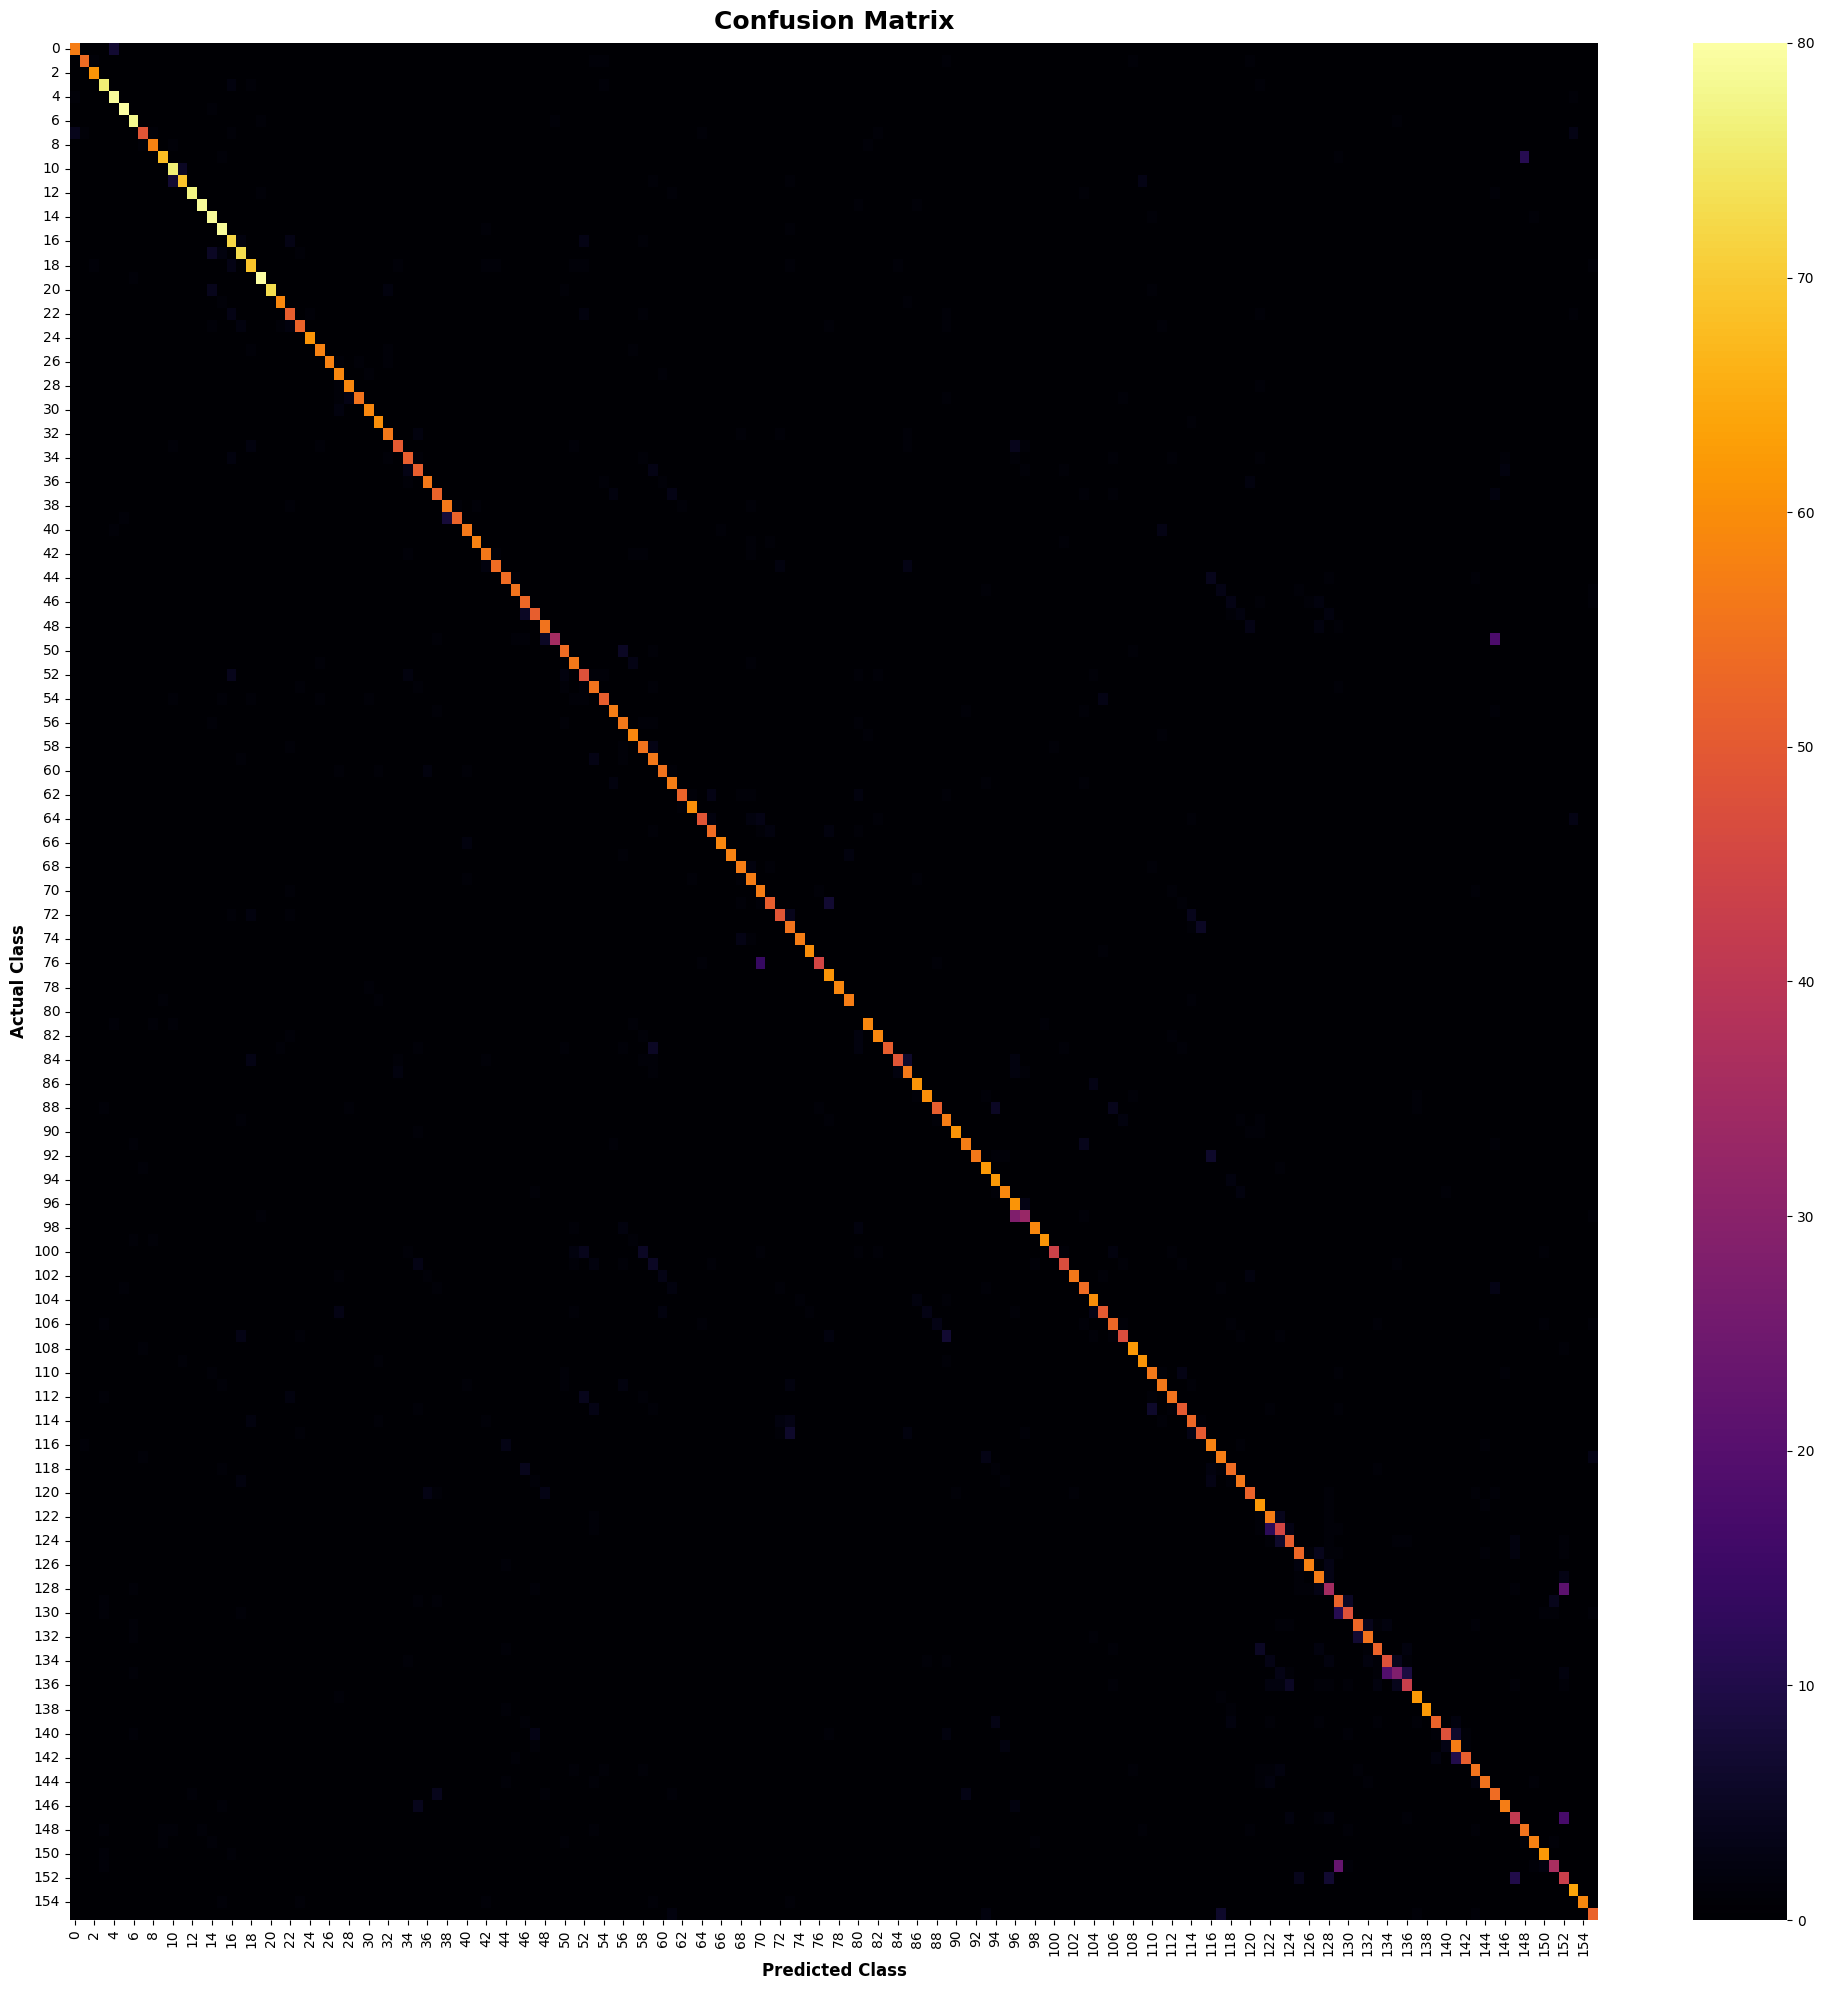

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the updated CSV file with original and predicted labels
df = pd.read_csv('/kaggle/working/updated_train_CNN-SA-DCA.csv')

# Extract true labels and predicted labels
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(156))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate macro average for precision, recall, and F1 score
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

# Calculate micro average for precision, recall, and F1 score
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

# Sensitivity (same as recall)
sensitivity = recall_macro

# Specificity calculation for each class
specificity = []
for i in range(156):
    tn = cm.sum() - (cm[:, i].sum() + cm[i, :].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

avg_specificity = sum(specificity) / len(specificity)

# Print calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro Average): {precision_macro:.4f}")
print(f"Recall (Macro Average / Sensitivity): {recall_macro:.4f}")
print(f"F1 Score (Macro Average): {f1_macro:.4f}")
print(f"Specificity (Macro Average): {avg_specificity:.4f}")
print(f"Precision (Micro Average): {precision_micro:.4f}")
print(f"Recall (Micro Average): {recall_micro:.4f}")
print(f"F1 Score (Micro Average): {f1_micro:.4f}")

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='inferno', fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()


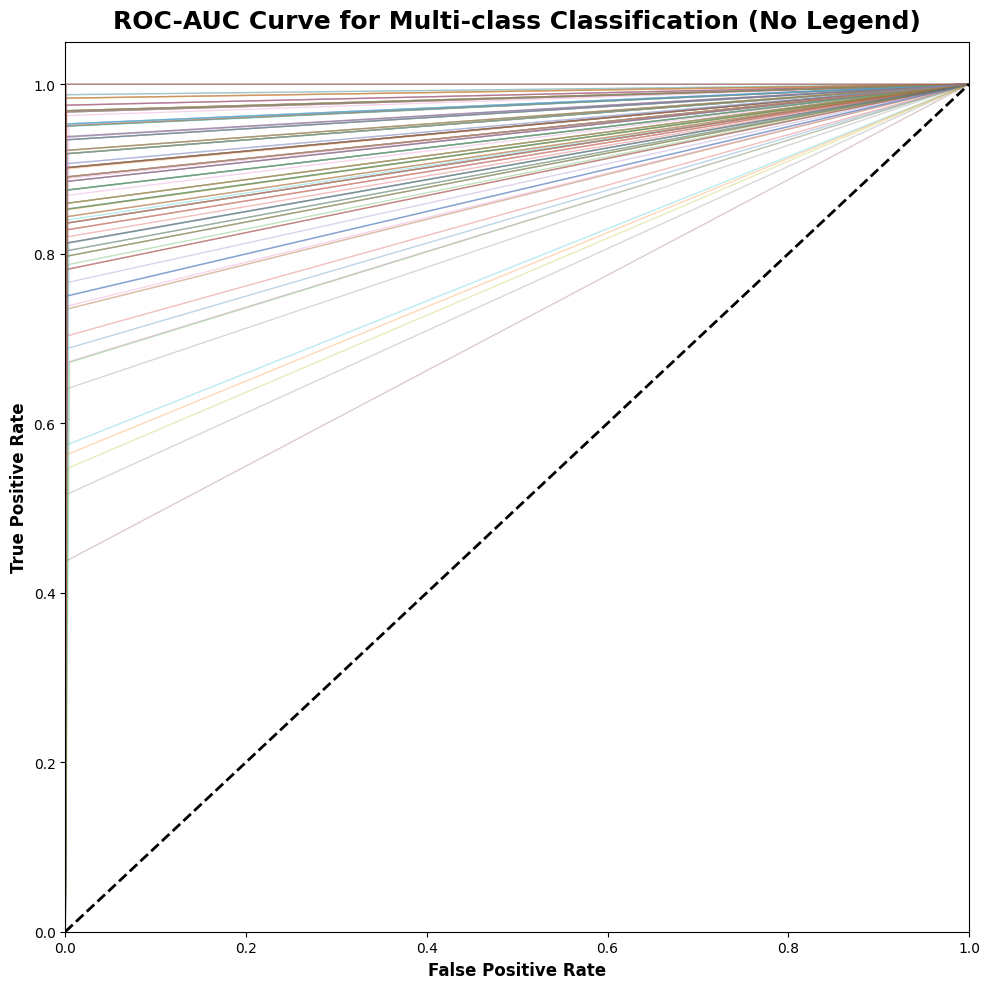

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the updated CSV file with original and predicted labels
df = pd.read_csv('/kaggle/working/updated_train_CNN-SA-DCA.csv')

# Extract true labels and predicted labels
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

# Binarize the output labels for multi-class ROC-AUC curve
y_true_bin = label_binarize(y_true, classes=range(156))
y_pred_bin = label_binarize(y_pred, classes=range(156))

# Calculate macro-average ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(156):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(156)]))
tpr_macro = np.zeros_like(fpr_macro)

for i in range(156):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])

tpr_macro /= 156
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_macro, tpr_macro, color='blue', label=f'Macro-average ROC curve (AUC = {roc_auc_macro:.4f})', linewidth=2)

# Plot ROC for each class without legend
for i in range(156):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-class Classification (No Legend)')
plt.show()

# CNN-SA

In [26]:
class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add your build logic here
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Add your call logic here
        return inputs  # Replace with actual logic

    def get_config(self):
        config = super(SelfAttention, self).get_config()
        # Add your additional config if needed
        return config

In [28]:
# model = tf.keras.models.load_model('/kaggle/working/model-CNN+SA+DCA.h5')
custom_objects = {'SelfAttention': SelfAttention}
model = tf.keras.models.load_model('/kaggle/input/abelation-models/model-CNNSA (1).h5', custom_objects=custom_objects)

In [33]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Load the CSV file
df = pd.read_csv('/kaggle/input/thcr-1/train.csv')

# Define the path to the images
image_path = '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/'

# Load your model (replace with actual model loading code)
# model = your_model_loading_function()

def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(64, 64))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_processed,verbose=0)
    index = np.argmax(prediction)
    return index

# Select only the first 50 rows
df_first_10000 = df.head(10000)

# Predict class labels and add to dataframe
df_first_10000['Predicted_Class_Label'] = df_first_10000['ID'].apply(
    lambda x: predict_image(os.path.join(image_path, f"{x}"), model)
)

# Save the updated CSV file
df_first_10000.to_csv('/kaggle/working/updated_train_CNN-SA.csv', index=False)

Accuracy: 0.9287
Precision (Macro Average): 0.9264
Recall (Macro Average / Sensitivity): 0.9220
F1 Score (Macro Average): 0.9226
Specificity (Macro Average): 0.9995
Precision (Micro Average): 0.9287
Recall (Micro Average): 0.9287
F1 Score (Micro Average): 0.9287


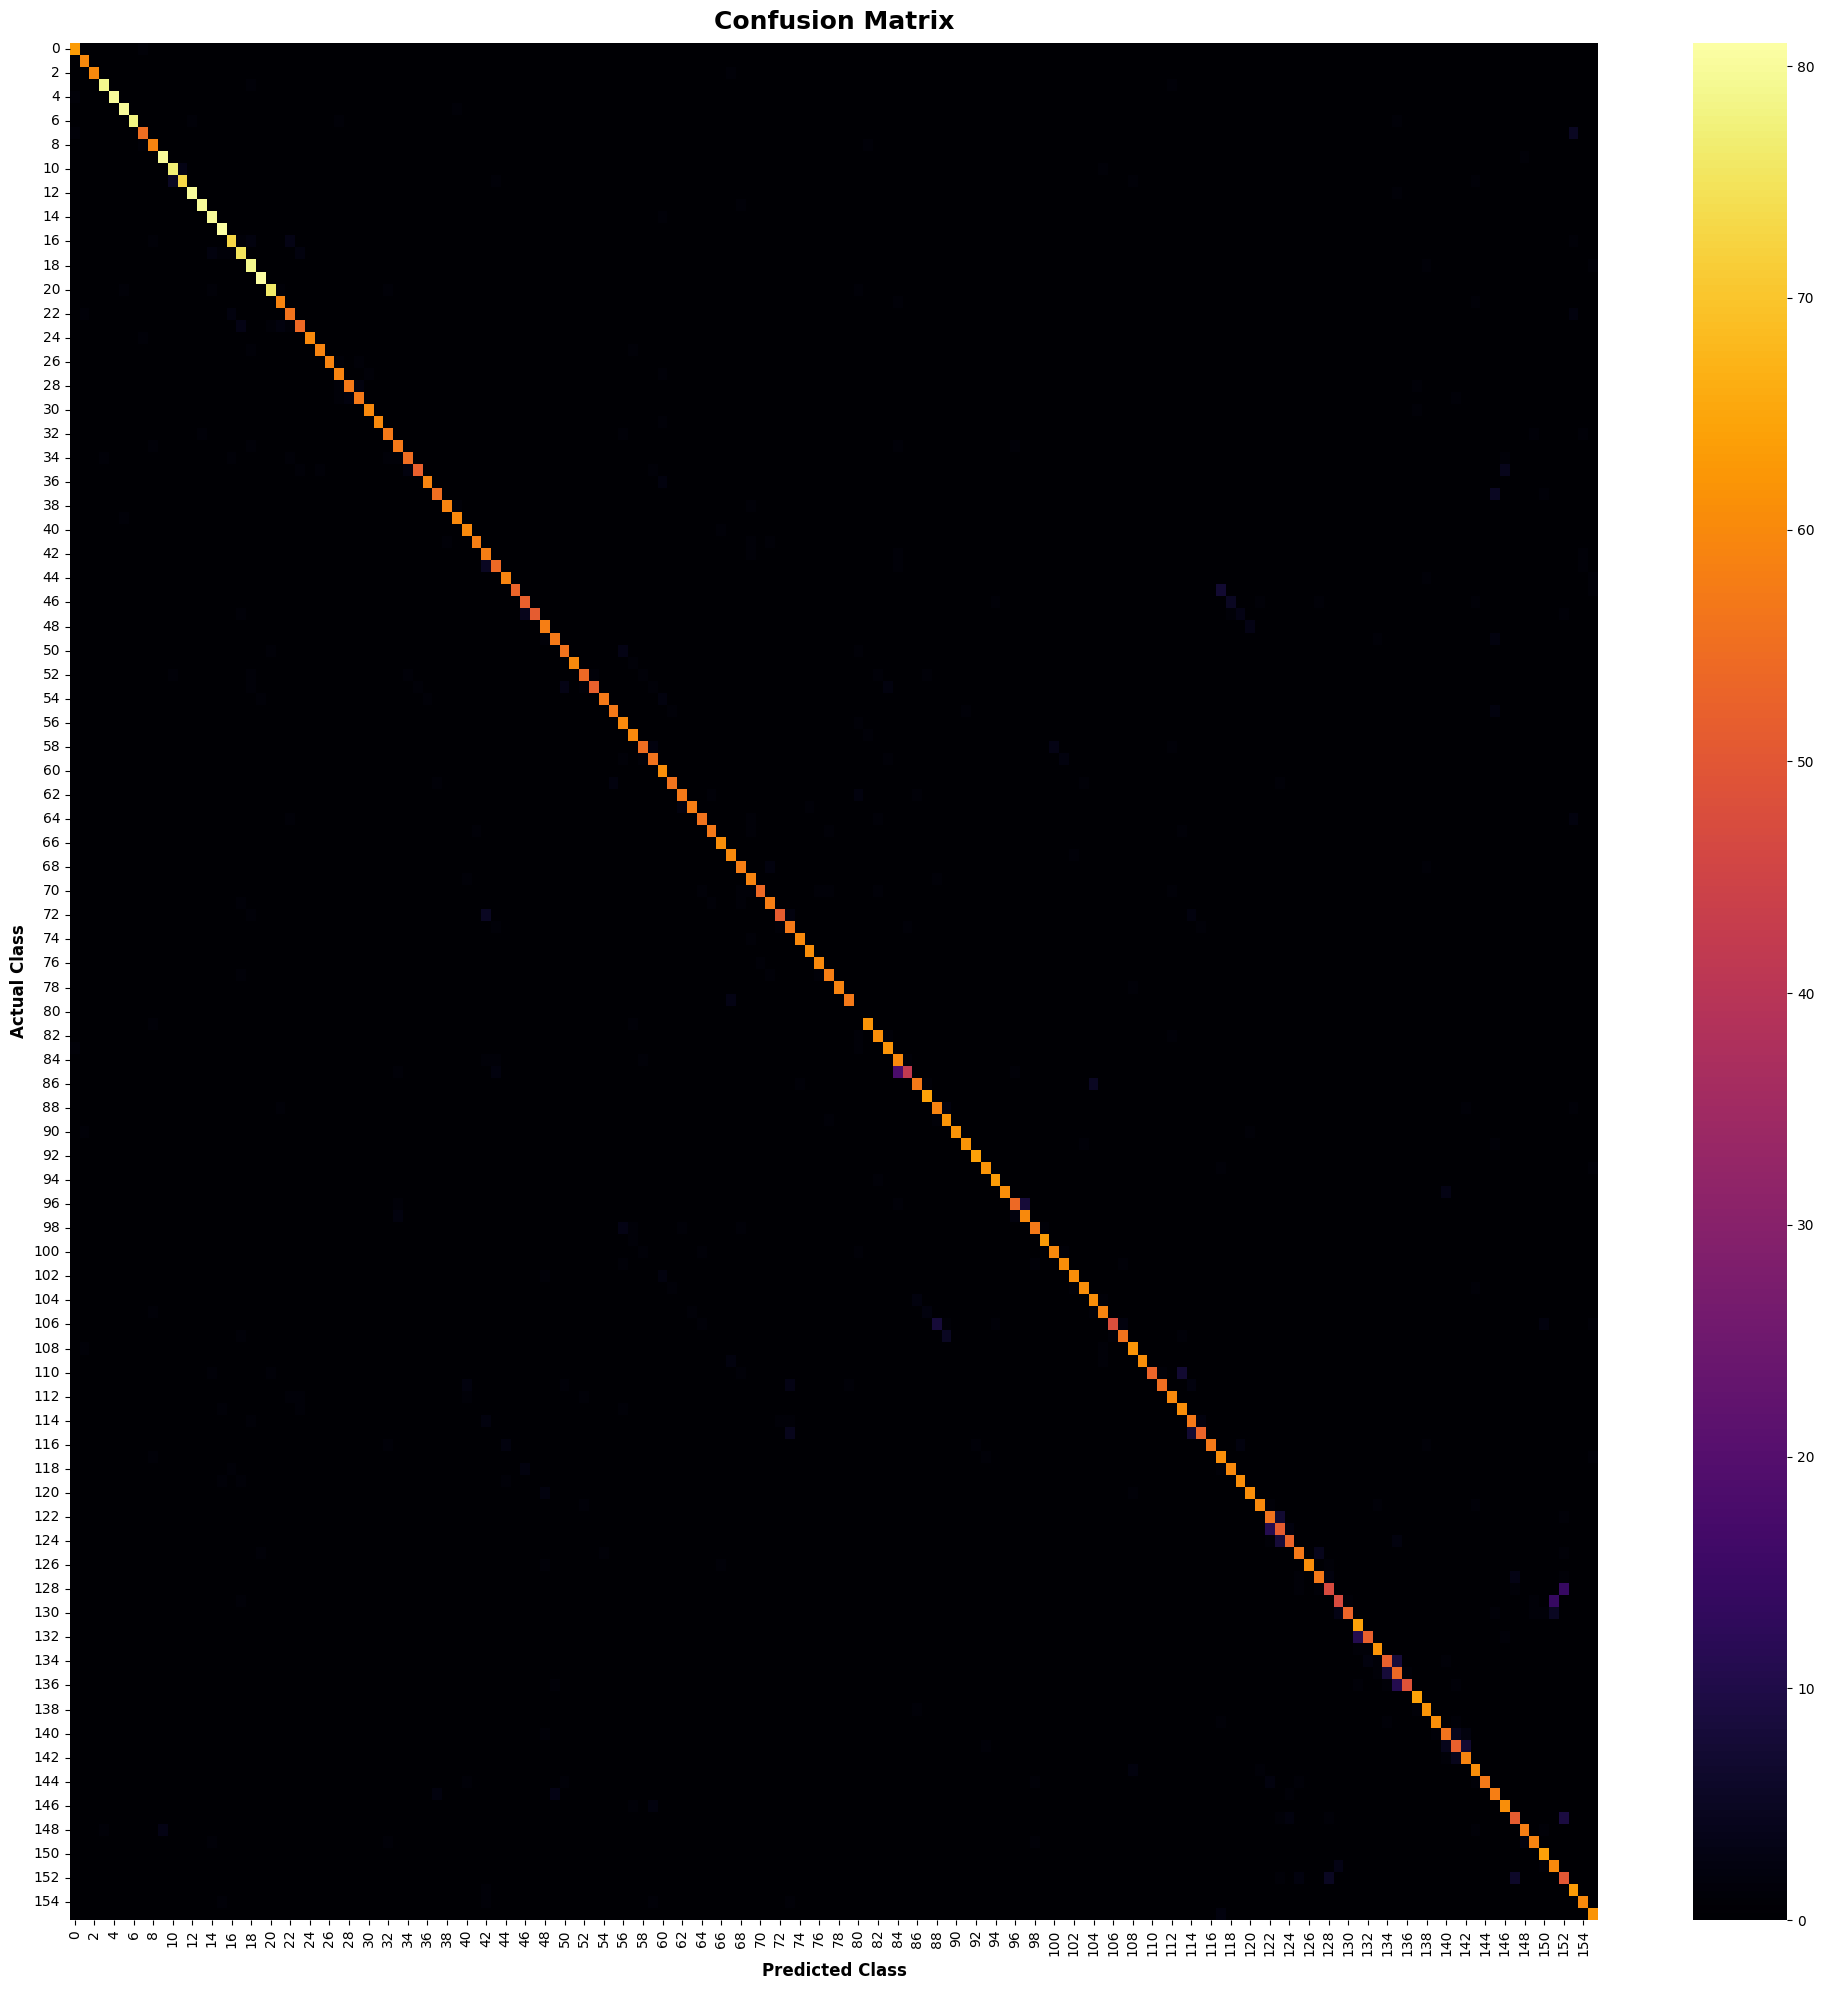

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the updated CSV file with original and predicted labels
df = pd.read_csv('/kaggle/working/updated_train_CNN-SA.csv')

# Extract true labels and predicted labels
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(156))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate macro average for precision, recall, and F1 score
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

# Calculate micro average for precision, recall, and F1 score
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

# Sensitivity (same as recall)
sensitivity = recall_macro

# Specificity calculation for each class
specificity = []
for i in range(156):
    tn = cm.sum() - (cm[:, i].sum() + cm[i, :].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

avg_specificity = sum(specificity) / len(specificity)

# Print calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro Average): {precision_macro:.4f}")
print(f"Recall (Macro Average / Sensitivity): {recall_macro:.4f}")
print(f"F1 Score (Macro Average): {f1_macro:.4f}")
print(f"Specificity (Macro Average): {avg_specificity:.4f}")
print(f"Precision (Micro Average): {precision_micro:.4f}")
print(f"Recall (Micro Average): {recall_micro:.4f}")
print(f"F1 Score (Micro Average): {f1_micro:.4f}")

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='inferno', fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()


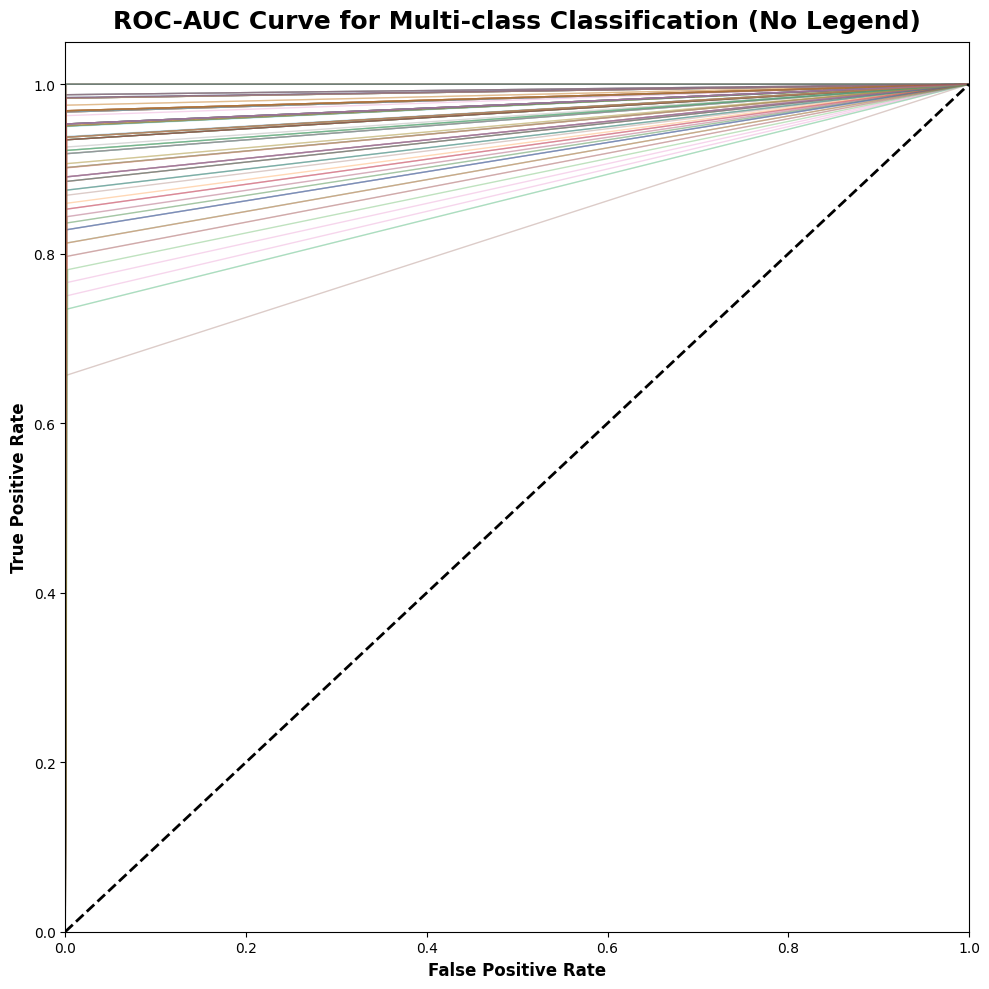

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the updated CSV file with original and predicted labels
df = pd.read_csv('/kaggle/working/updated_train_CNN-SA.csv')

# Extract true labels and predicted labels
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

# Binarize the output labels for multi-class ROC-AUC curve
y_true_bin = label_binarize(y_true, classes=range(156))
y_pred_bin = label_binarize(y_pred, classes=range(156))

# Calculate macro-average ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(156):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(156)]))
tpr_macro = np.zeros_like(fpr_macro)

for i in range(156):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])

tpr_macro /= 156
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_macro, tpr_macro, color='blue', label=f'Macro-average ROC curve (AUC = {roc_auc_macro:.4f})', linewidth=2)

# Plot ROC for each class without legend
for i in range(156):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-class Classification (No Legend)')
plt.show()

# CNN-DCA

In [36]:
custom_objects = {'DenseChannelAttention': DenseChannelAttention}
model= tf.keras.models.load_model('/kaggle/input/abelation-models/model-CNNDCA.h5', custom_objects=custom_objects)

In [37]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Load the CSV file
df = pd.read_csv('/kaggle/input/thcr-1/train.csv')

# Define the path to the images
image_path = '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/'

def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(64, 64))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_processed,verbose=0)
    index = np.argmax(prediction)
    return index

# Select only the first 50 rows
df_first_10000 = df.head(10000)

# Predict class labels and add to dataframe
df_first_10000['Predicted_Class_Label'] = df_first_10000['ID'].apply(
    lambda x: predict_image(os.path.join(image_path, f"{x}"), model)
)

# Save the updated CSV file
df_first_10000.to_csv('/kaggle/working/updated_train_CNN-DCA.csv', index=False)

Accuracy: 0.9167
Precision (Macro Average): 0.9152
Recall (Macro Average / Sensitivity): 0.9101
F1 Score (Macro Average): 0.9106
Specificity (Macro Average): 0.9995
Precision (Micro Average): 0.9167
Recall (Micro Average): 0.9167
F1 Score (Micro Average): 0.9167


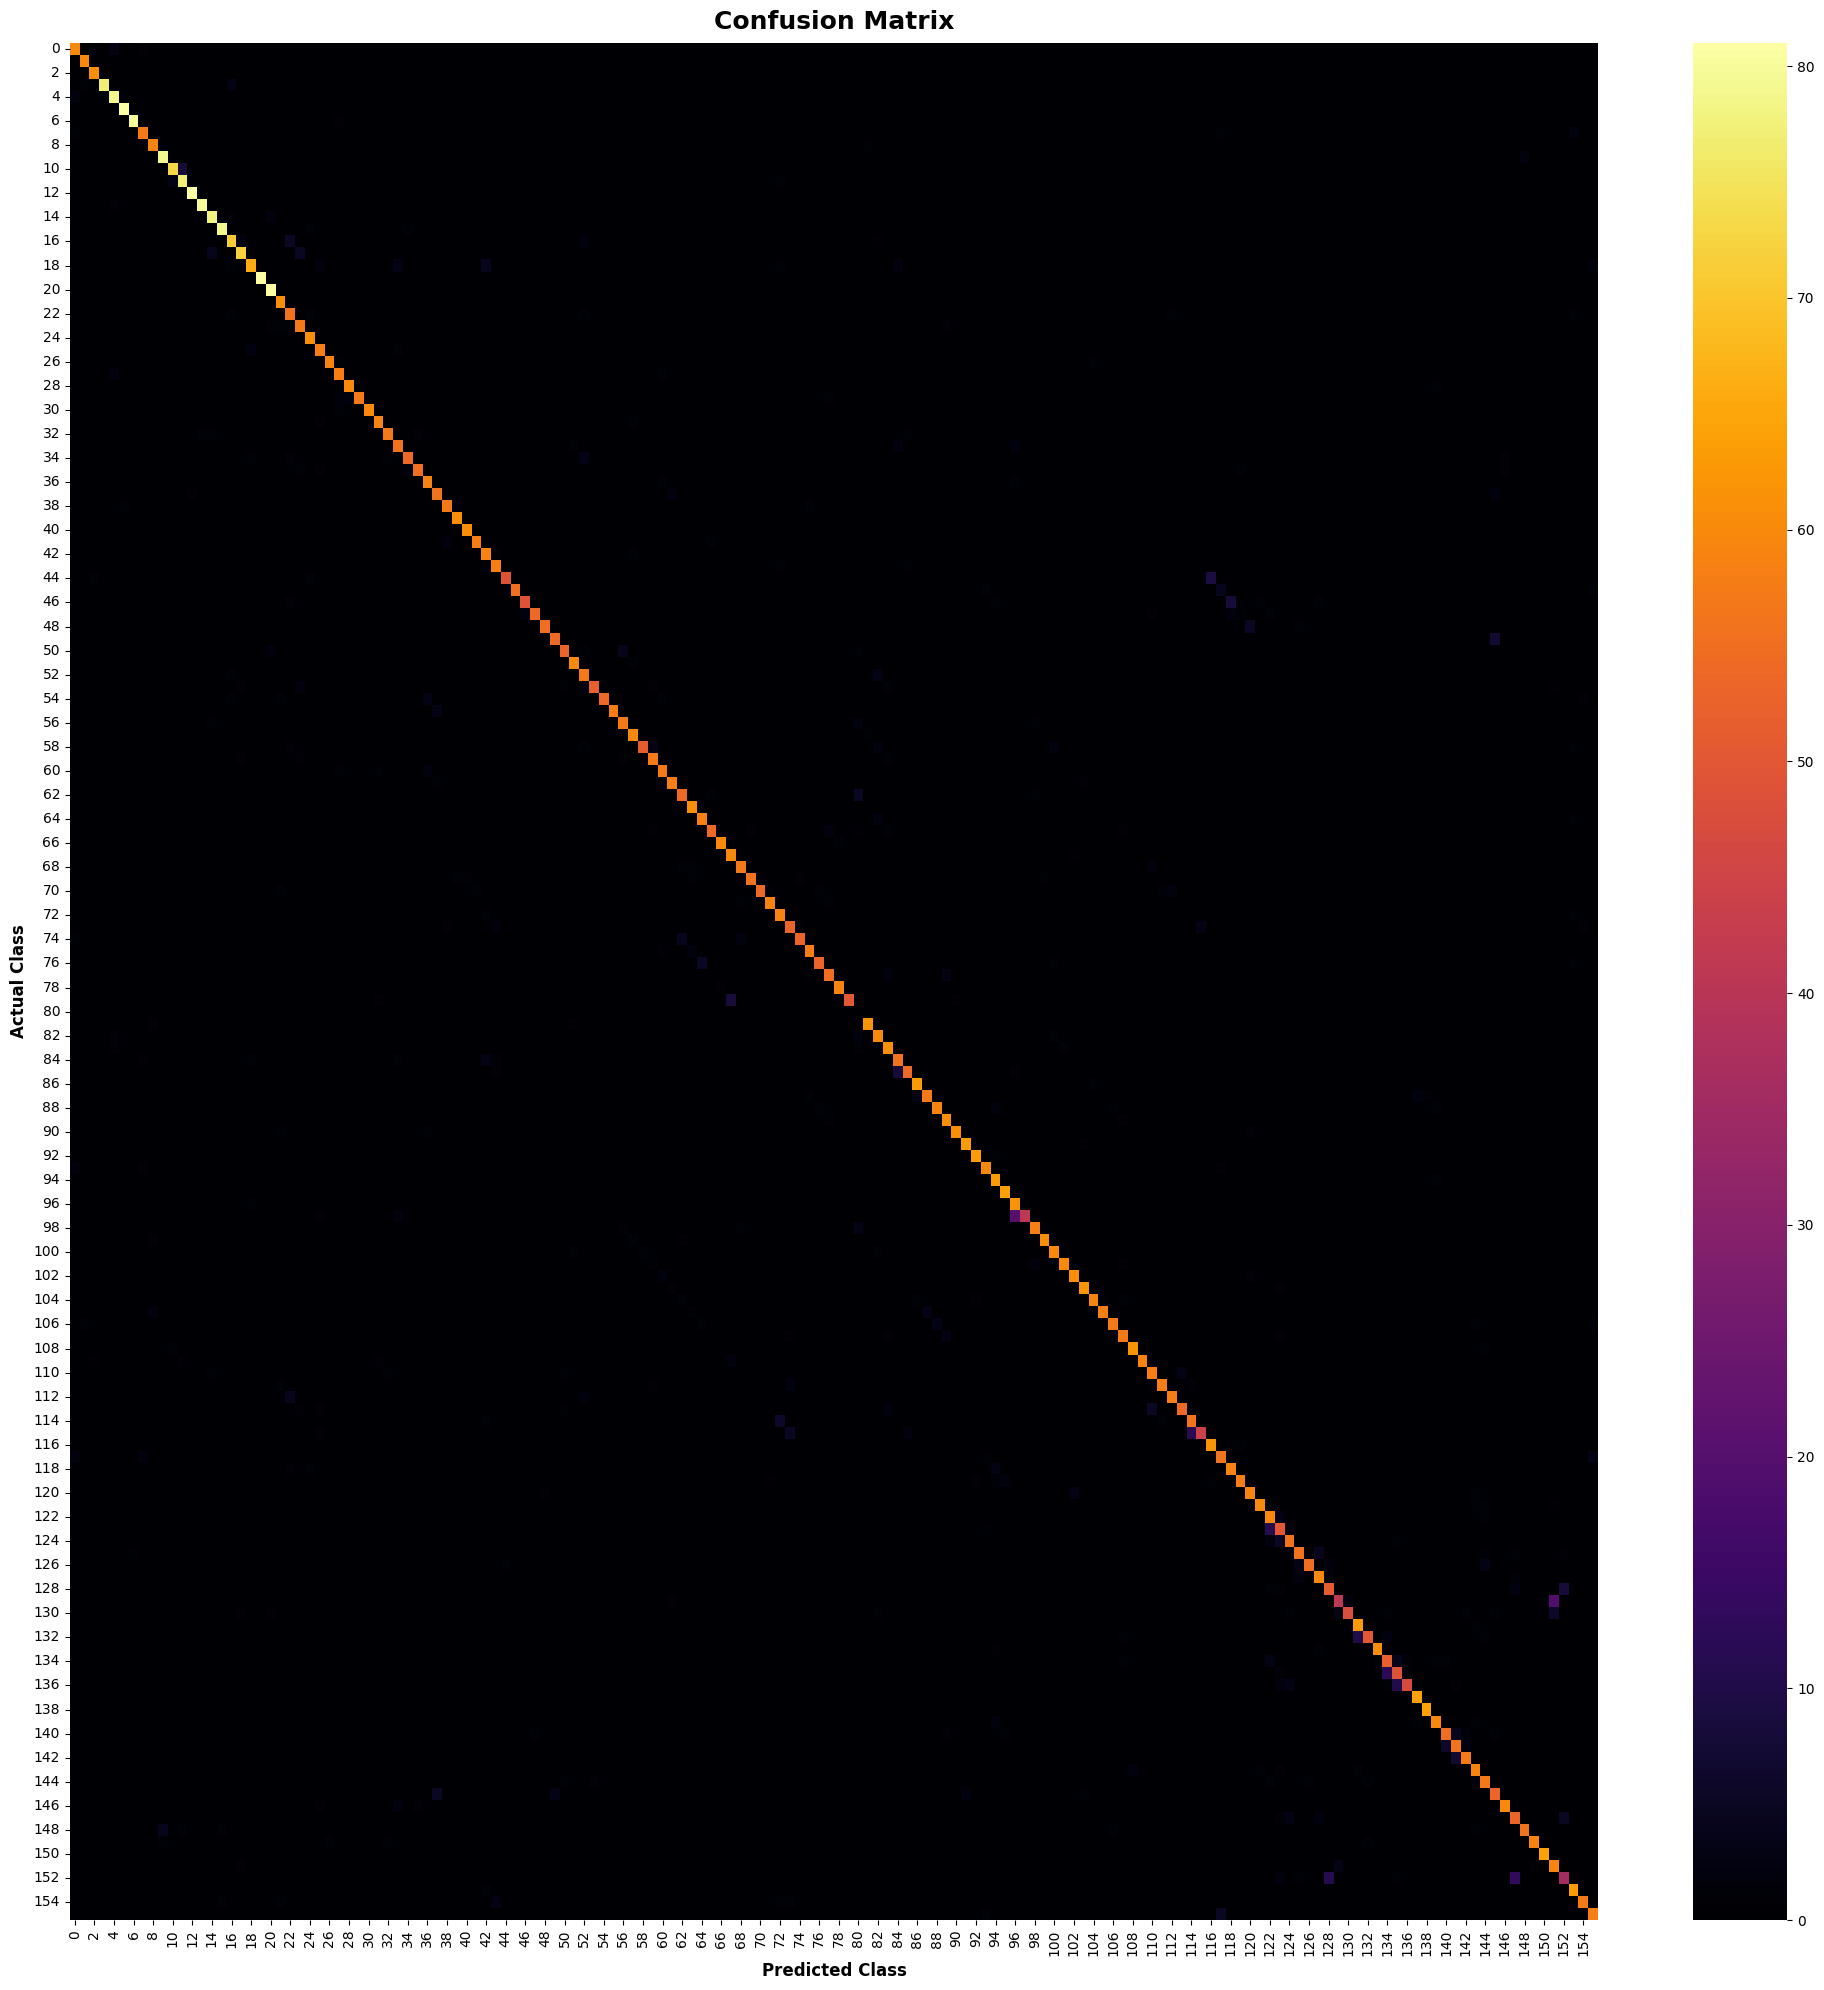

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the updated CSV file with original and predicted labels
df = pd.read_csv('/kaggle/working/updated_train_CNN-DCA.csv')

# Extract true labels and predicted labels
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(156))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate macro average for precision, recall, and F1 score
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

# Calculate micro average for precision, recall, and F1 score
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

# Sensitivity (same as recall)
sensitivity = recall_macro

# Specificity calculation for each class
specificity = []
for i in range(156):
    tn = cm.sum() - (cm[:, i].sum() + cm[i, :].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

avg_specificity = sum(specificity) / len(specificity)

# Print calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro Average): {precision_macro:.4f}")
print(f"Recall (Macro Average / Sensitivity): {recall_macro:.4f}")
print(f"F1 Score (Macro Average): {f1_macro:.4f}")
print(f"Specificity (Macro Average): {avg_specificity:.4f}")
print(f"Precision (Micro Average): {precision_micro:.4f}")
print(f"Recall (Micro Average): {recall_micro:.4f}")
print(f"F1 Score (Micro Average): {f1_micro:.4f}")

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='inferno', fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()


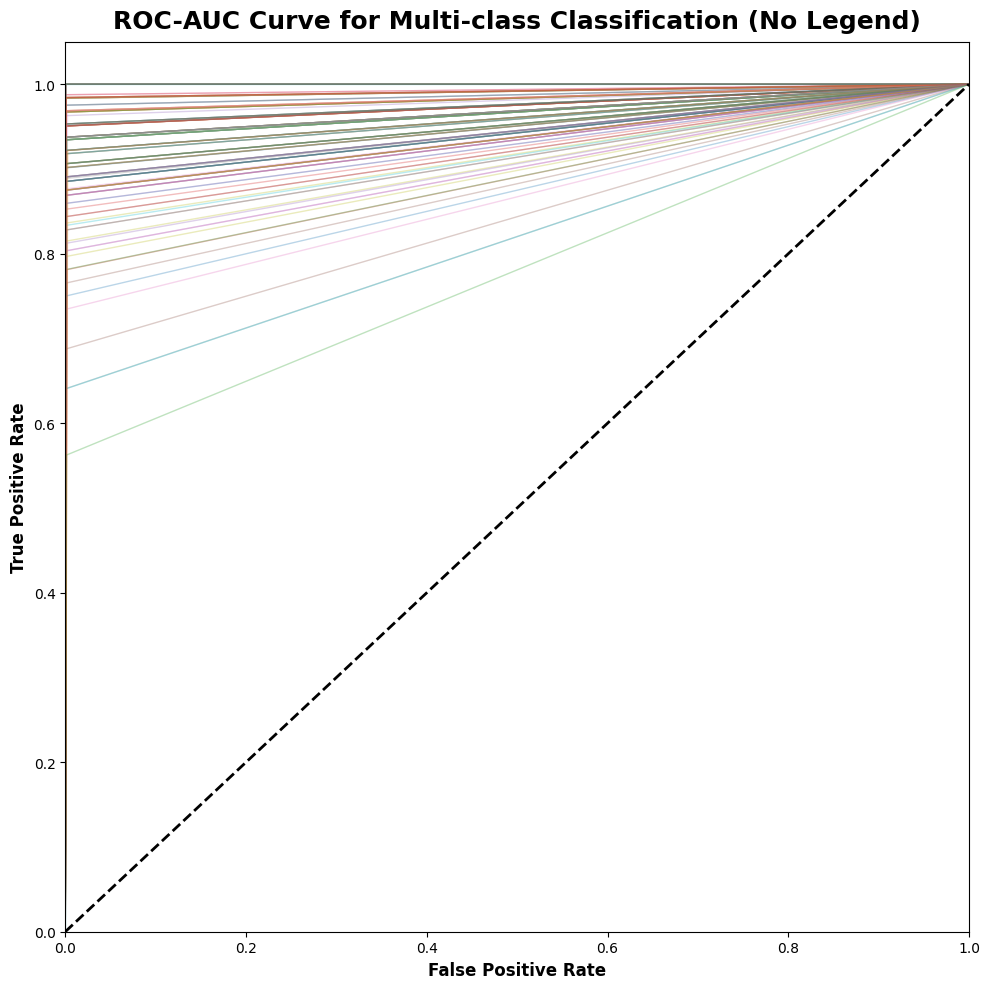

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the updated CSV file with original and predicted labels
df = pd.read_csv('/kaggle/working/updated_train_CNN-DCA.csv')

# Extract true labels and predicted labels
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

# Binarize the output labels for multi-class ROC-AUC curve
y_true_bin = label_binarize(y_true, classes=range(156))
y_pred_bin = label_binarize(y_pred, classes=range(156))

# Calculate macro-average ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(156):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(156)]))
tpr_macro = np.zeros_like(fpr_macro)

for i in range(156):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])

tpr_macro /= 156
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr_macro, tpr_macro, color='blue', label=f'Macro-average ROC curve (AUC = {roc_auc_macro:.4f})', linewidth=2)

# Plot ROC for each class without legend
for i in range(156):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-class Classification (No Legend)')
plt.show()